In [52]:
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import pims, sys
from pathlib import Path
sys.path.insert(0, r'C:\\Warwick\\Jerko_Code_And_Docs\\Manuscript Code')
from Filament_Analysis.geometric_2 import SimpleSpline
from skimage.filters import threshold_niblack
from skimage.morphology import opening, disk
from skimage.measure import regionprops, label

### 22-Feb-23_tirf-5


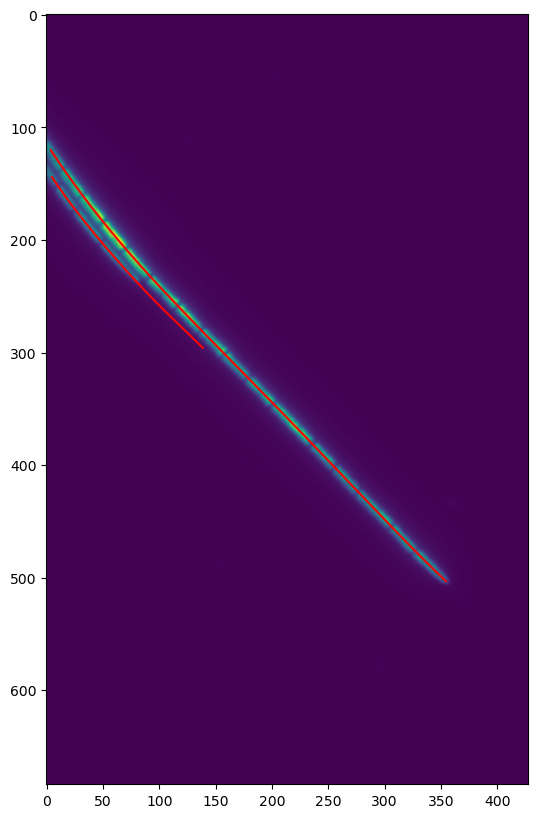

In [63]:
@pims.pipeline
def crop_image(frame):
    return frame[:,428:]

# Stack and file paths, here we have two stacks that will be combined later.
base_path = Path(r'C:\Users\jrosk\Dropbox\Warwick\TIRF\February_2023\22-02-2023\Untreated_Sample')
filepath = base_path.joinpath(r'Slides\Slide_1\22-Feb-23_tirf-5.tif')

# Open and crop image to red channel
images_ = pims.open(filepath.as_posix())
images = crop_image(images_)

# There are two filaments in this video, this works to segment the top
image_top = images[0]
binary_top = image_top > threshold_niblack(image_top, window_size=19, k =0.1)
binary_top = opening(binary_top, disk(2))


labelled_top = label(binary_top)
for region in regionprops(labelled_top):
      if region.area < 900:
            labelled_top[labelled_top== region.label] = 0
      else: 
            labelled_top[labelled_top== region.label] = 1

#there is bit sticking out to fix
for rr in range(labelled_top.shape[0]):
      if rr < 117:
            labelled_top[rr,:]=0

# For the bottom
binary_bot = images[745] > threshold_niblack(images[745], window_size=29)
binary_bot = opening(binary_bot, disk(2))


labelled_bot = label(binary_bot)
for region in regionprops(labelled_bot):
    # take regions with large enough areas
        if region.area  <  150:
            labelled_bot[labelled_bot== region.label] = 0
        elif region.area > 900:
            labelled_bot[labelled_bot== region.label] = 0
        else:
            labelled_bot[labelled_bot==region.label]  = 1
              
# Spline them

filament_axis_top = SimpleSpline.from_binary_image(dx=0.01,input_image=labelled_top>0, spline_k = 5)
filament_axis_bot = SimpleSpline.from_binary_image(dx=0.01,input_image=labelled_bot>0, spline_k = 5)

fig, ax = plt.subplots(1,1, figsize = (10,10))


plt.imshow(labelled_top + 2*labelled_bot)
plt.imshow(images[0])
plt.plot(filament_axis_top.xy[:,0], filament_axis_top.xy[:,1], color='red')
plt.plot(filament_axis_bot.xy[:,0], filament_axis_bot.xy[:,1], color='red')


In [43]:
np.savetxt(r'splines\spline_top_15_10_23.txt', filament_axis_top.xy, delimiter = ',', header = 'Spline 15/10/23 Top')
np.savetxt(r'splines\spline_bot_15_10_23.txt', filament_axis_bot.xy, delimiter = ',', header = 'Spline 15/10/23 Bot')